# Oregon Wildlife - Image Classification Capstone - Model Optimization with Batch Normalization 

## David Lappin
### BrainStation
#### 3/1/2023 - 4/10/2023

# Packages Import:

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL 
from glob import glob
import seaborn as sns
import visualkeras


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Import Data:

In [4]:
#set local path to files for basic exploration

trainpath = 'data/oregon_wildlife/' # This is the relative path to the data
valpath = 'data/oregon_wildlife_validation/' # This is the relative path to the data
testpath = 'data/oregon_wildlife_test/' # This is the relative path to the data

Ensure Data is still in the same state as we left it from the previous EDA before modeling.

In [5]:
#check number of images in train folder

totalcount_train = []
image_files = os.listdir(trainpath)

for file in image_files:
    
    count = len(list(glob(f'data/oregon_wildlife/{file}/*')))
    totalcount_train.append(count)
    print(f'{count}: {file}')
    
print(f'Total images: {sum(totalcount_train)}')

588: bald_eagle
560: black_bear
535: bobcat
558: canada_lynx
580: columbian_black-tailed_deer
518: cougar
581: coyote
608: deer
505: elk
513: gray_fox
575: gray_wolf
420: mountain_beaver
536: nutria
569: raccoon
495: raven
602: red_fox
426: ringtail
540: seals
570: sea_lions
571: virginia_opossum
Total images: 10850


In [6]:
#check number of images in Validation folder

totalcount_validation = []
image_files = os.listdir(valpath)
for file in image_files:
    
    count = len(list(glob(f'data/oregon_wildlife_validation/{file}/*')))
    totalcount_validation.append(count)
    print(f'{count}: {file}')
    
print(f'Total images: {sum(totalcount_validation)}')

135: bald_eagle
135: black_bear
135: bobcat
135: canada_lynx
135: columbian_black-tailed_deer
135: cougar
135: coyote
135: deer
135: elk
135: gray_fox
135: gray_wolf
135: mountain_beaver
135: nutria
135: raccoon
135: raven
135: red_fox
135: ringtail
135: seals
135: sea_lions
135: virginia_opossum
Total images: 2700


In [7]:
#check number of images in test folder

totalcount_test = []
image_files = os.listdir(testpath)

for file in image_files:
    
    count = len(list(glob(f'data/oregon_wildlife_test/{file}/*')))
    totalcount_test.append(count)
    print(f'{count}: {file}')
    
print(f'Total images: {sum(totalcount_test)}')

20: bald_eagle
20: black_bear
20: bobcat
20: canada_lynx
20: columbian_black-tailed_deer
20: cougar
20: coyote
20: deer
20: elk
20: gray_fox
20: gray_wolf
20: mountain_beaver
20: nutria
20: raccoon
20: raven
20: red_fox
20: ringtail
20: seals
20: sea_lions
20: virginia_opossum
Total images: 400


### Observations: 
Everything looks the same.

# Prepare Data:

In [8]:
#define image loading parameters 

batch_size = 32 #use batch size of 32 images 
img_height = 180 
img_width = 180

For now we are goin to leave the hieght and widgth at 180x180. If we need to reduce the complexity of the photos later for modeling we can reduce these values.

In [9]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  trainpath,
  label_mode='int',
  seed=7,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_set = tf.keras.preprocessing.image_dataset_from_directory(
  valpath,
  label_mode='int',
  seed=7,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10850 files belonging to 20 classes.
Found 2700 files belonging to 20 classes.


**Note** These values match the counts from the directory above. 

# Create and Compile Updated Model

Similar to our preliminary compatibility testing in the EDA section we are going to create a simple Convolutional Neural Network (CNN) based in TF/Keras for our baseline model.

In [10]:
#save and check class_names in the training set

class_names = train_set.class_names
len(class_names)


20

Below:
- **Autotune** allows for CPU performance optimizaiton
- **Cache** - stores imported images in memory for future epoch iterations
- **prefetch** - allows for overlapping of preprocess and training

In [11]:
#adjust the prefetching for performance

AUTOTUNE = tf.data.AUTOTUNE #Autotune optimizes CPU uptime for each batch

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #cache stores data in memory after 1st epoch for faster iterations
val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE) #prefetch allows for overlapping 



##### SOURCE:
https://www.tensorflow.org/tutorials/images/classification#data_augmentation

In [12]:
# creates an augmentation sequence that can be used on a single example to create new variations

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

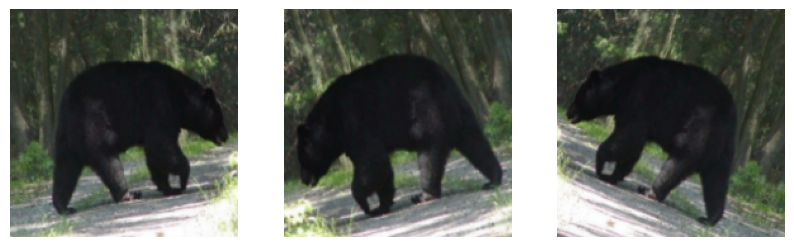

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_set.take(1):
  for i in range(3):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [15]:
num_classes = len(class_names)
img_height = 180
img_width = 180

Batchnorm_model = Sequential([
  
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  data_augmentation,  
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),  
  layers.MaxPooling2D(),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
   
    
  #Flatten  
  layers.Flatten(),
    
  #Dense Layers  
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),  
  layers.Dense(num_classes, activation = 'softmax')
])


Compile the model using:
- Adam Optimzer (high performing gradient decent method, default learning rate = 0.001)
 - note there are other options but we will stick with Adam
- SparseCategoricalCrossentropy loss calcualtion  (used when there are more than two classes or labels)

In [16]:
#compile the model

Batchnorm_model.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [17]:
Batchnorm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)       

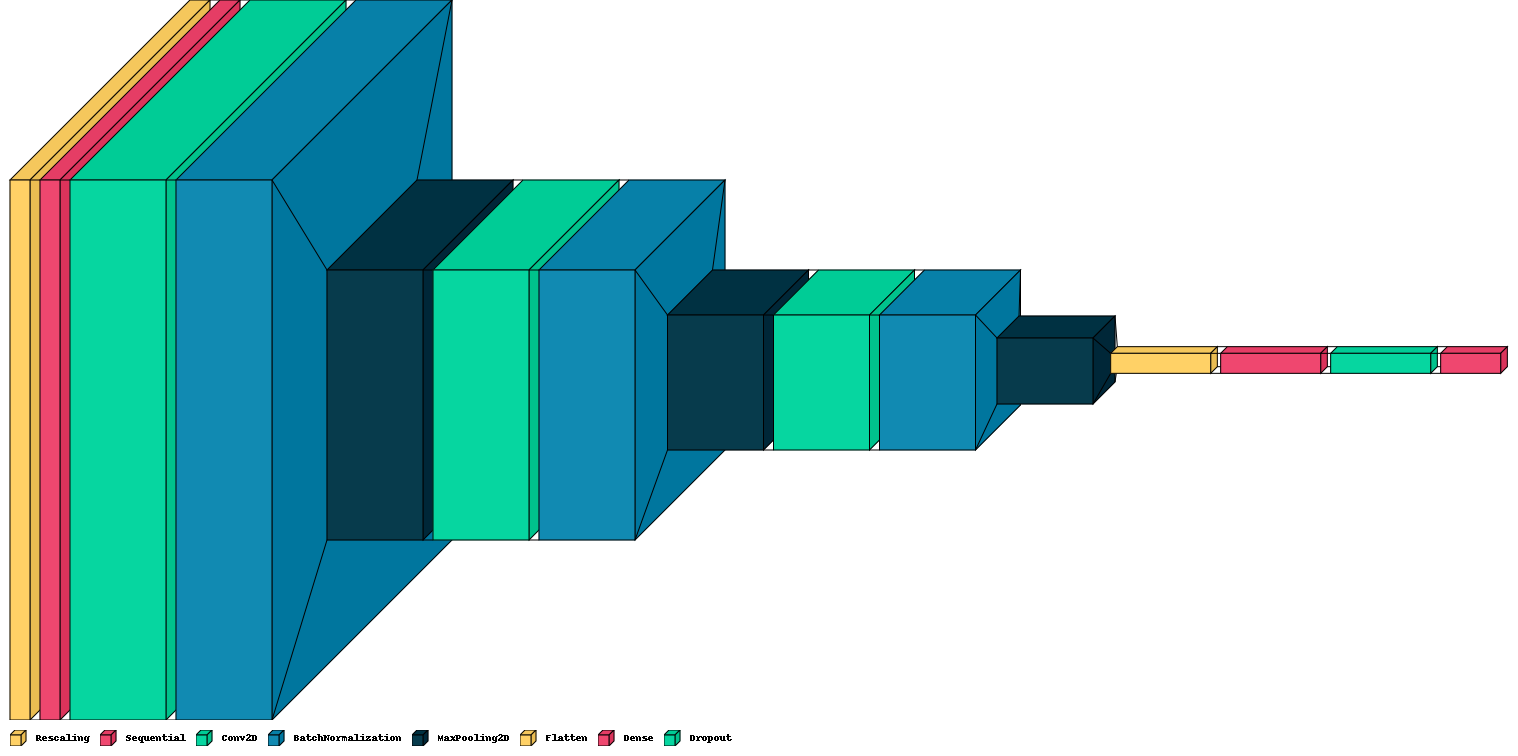

In [66]:
#visualize the model summary with VisualKeras
visualkeras.layered_view(Batchnorm_model, legend = True, draw_volume = True, scale_xy=3, scale_z=3, max_z=100, \
                         to_file = 'modelvisualizations/Batchnorm_model.png')


In our baseline model we have now compiled all the layers. There are ~2million trainable parameters, and we see our output layer is 20 which matches our class labels. 

Next we can fit our model to the training data using 75 epochs or until early stopped as defined by the callback below. Our model will be validated on the validation split. The test set will be saved for predictions later. 

In [22]:
# set stopping criteria

callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.05, patience=5)

In [24]:
#fit model for 75 epochs

epochs = 75

history = Batchnorm_model.fit(   
  train_set,            
  validation_data=val_set, 
  epochs=epochs,
  callbacks = [callbacks]
)

Epoch 1/75
340/340 [==============================] - 198s 575ms/step - loss: 3.0022 - accuracy: 0.0986 - val_loss: 4.3762 - val_accuracy: 0.0956
Epoch 2/75
340/340 [==============================] - 188s 553ms/step - loss: 2.8668 - accuracy: 0.1075 - val_loss: 2.8633 - val_accuracy: 0.1033
Epoch 3/75
340/340 [==============================] - 186s 546ms/step - loss: 2.8305 - accuracy: 0.1182 - val_loss: 2.8124 - val_accuracy: 0.1363
Epoch 4/75
340/340 [==============================] - 188s 554ms/step - loss: 2.7862 - accuracy: 0.1276 - val_loss: 2.8126 - val_accuracy: 0.1374
Epoch 5/75
340/340 [==============================] - 188s 553ms/step - loss: 2.7384 - accuracy: 0.1449 - val_loss: 2.7563 - val_accuracy: 0.1570
Epoch 6/75
340/340 [==============================] - 188s 553ms/step - loss: 2.6765 - accuracy: 0.1692 - val_loss: 2.7488 - val_accuracy: 0.1952
Epoch 7/75
340/340 [==============================] - 188s 552ms/step - loss: 2.6488 - accuracy: 0.1787 - val_loss: 2.8383 -

340/340 [==============================] - 198s 583ms/step - loss: 1.5582 - accuracy: 0.4944 - val_loss: 2.3228 - val_accuracy: 0.3637
Epoch 41/75
340/340 [==============================] - 196s 578ms/step - loss: 1.5411 - accuracy: 0.5032 - val_loss: 2.5680 - val_accuracy: 0.3726
Epoch 42/75
340/340 [==============================] - 204s 601ms/step - loss: 1.5070 - accuracy: 0.5179 - val_loss: 2.4829 - val_accuracy: 0.3789
Epoch 43/75
340/340 [==============================] - 197s 581ms/step - loss: 1.5039 - accuracy: 0.5115 - val_loss: 2.3720 - val_accuracy: 0.3830
Epoch 44/75
340/340 [==============================] - 198s 581ms/step - loss: 1.4861 - accuracy: 0.5225 - val_loss: 2.2890 - val_accuracy: 0.3707
Epoch 45/75
340/340 [==============================] - 187s 549ms/step - loss: 1.4487 - accuracy: 0.5305 - val_loss: 2.9015 - val_accuracy: 0.3411
Epoch 46/75
340/340 [==============================] - 182s 536ms/step - loss: 1.4413 - accuracy: 0.5331 - val_loss: 2.3495 - val_

#### Observations:

The model stopped (early stopping) at 11/25 epochs. We can now save the model for future loading and begin to visualize and evaluate our baseline model:

Save the model: (note this code is only needed if you plan to save the model weights after running)

In [25]:
#save the model weights for use in predictions later if desired

Batchnorm_model.save('models/Batch_normalization.h5')

# Preliminary Evaluation

We can visualize the model perfmormance.

##### SOURCE - plot code base from TF Guide:
https://www.tensorflow.org/tutorials/images/classification

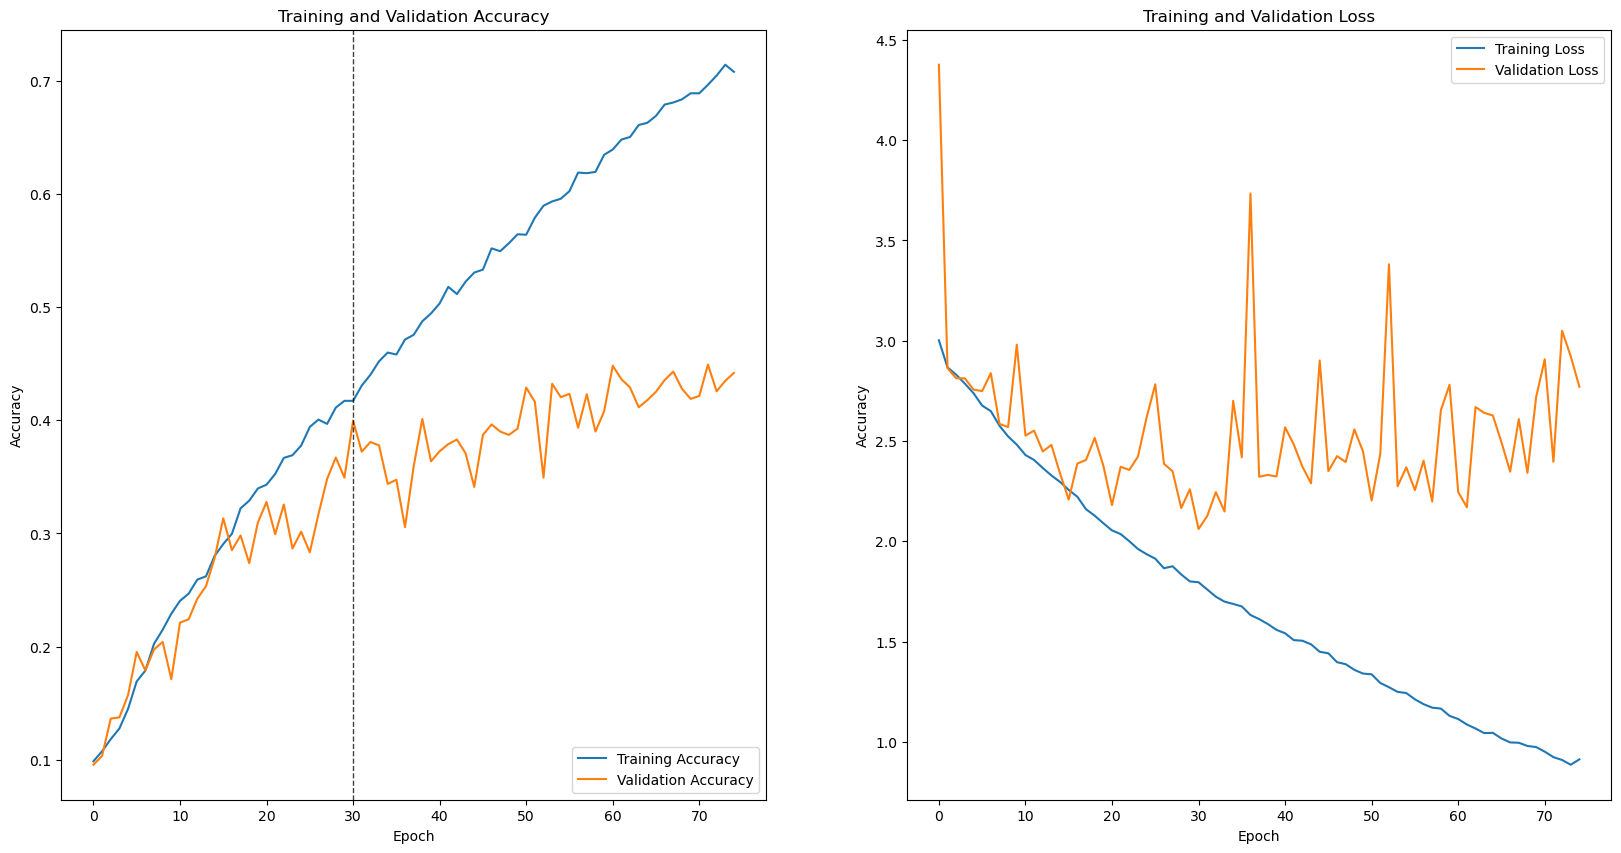

In [34]:
#visualize model performance after 30 

#pull out the accuracy and validation accuracies from model fit history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#pull out the loss data from the model fit history
loss = history.history['loss']
val_loss = history.history['val_loss']

#x lab range defined by the # of epochs ran
epochs_range = range(len(acc))

#training vs Validation Accuracies
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.axvline(30, color = "black", linestyle = '--', linewidth = 1, alpha = 0.75)
#plt.axhline(0.41, color = "black", linestyle = '-', linewidth = 1, alpha = 0.75, label = 'Optimal Epochs (30)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#visualize loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations

# Import Test Data and Make Predictions

In [35]:
#import test set directory for predictions

test_set = tf.keras.preprocessing.image_dataset_from_directory(
  testpath,
  image_size=(img_height, img_width),
  label_mode = 'categorical') #since these are not for training we can load as categorical rather than integer

Found 400 files belonging to 20 classes.


#### SOURCE

Found way to extract multiple predictions across whole dataset from answer by (Frightera, 2021)
https://stackoverflow.com/questions/68121629/trying-to-extract-y-val-from-dataset-throws-all-the-input-arrays-must-have-same

In [36]:
#generate predictions on test data

predictions = np.array([]) #empty list for predictions
labels =  np.array([]) #empty list for labels


for x, y in test_set:
  
  #generate predictions 
  predictions = np.concatenate([predictions, np.argmax(Batchnorm_model.predict(x), axis = -1)]) 

  #generate true labels
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

1/1 [==============================] - 0s 118ms/step


In [37]:
# generate a tensorflow confusion matrix from the predictions and true labels above

con_mat = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

In [38]:
#normalize the values such that they fit on a 0-1 scale
normalized_conf_mat = con_mat / con_mat.sum(axis=1)

In [39]:
#define the class names and create temp dataframe to that we can plot using the class names (instead of integers)

class_names = test_set.class_names
con_mat_df = pd.DataFrame(normalized_conf_mat, index=class_names, columns=class_names)

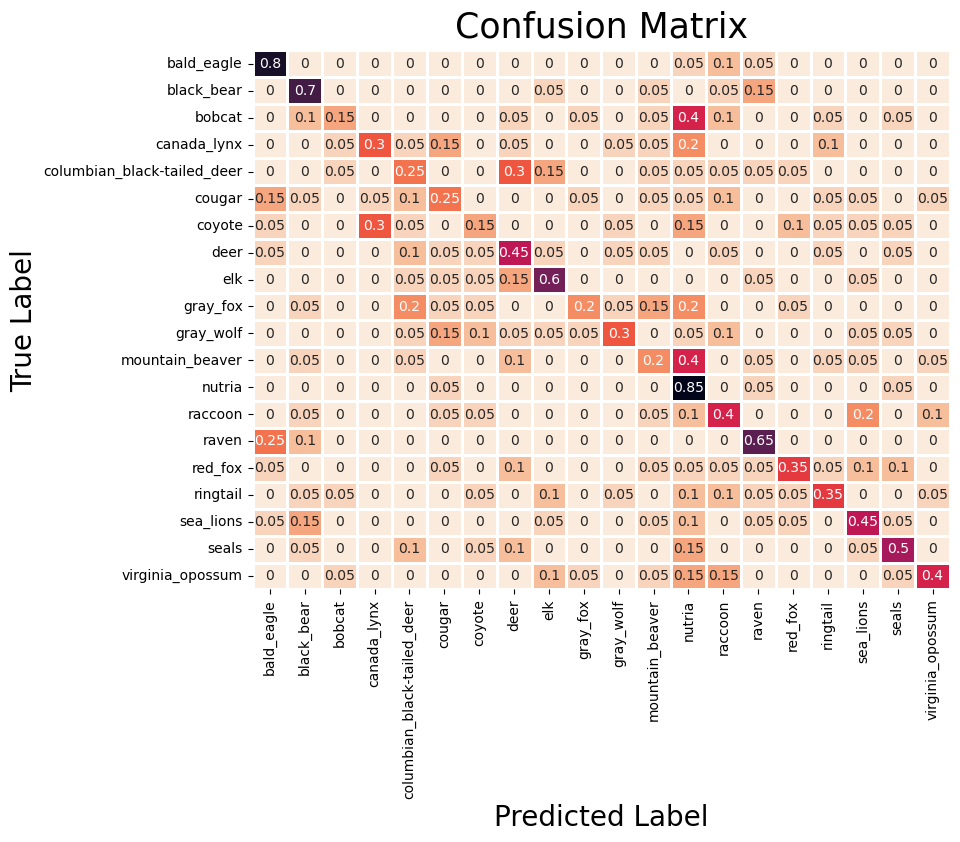

In [40]:
#plot confusion matrix using the data frame with class names created above
plt.figure(figsize = (9,7))
sns.heatmap(con_mat_df,
            annot=True,
            cbar=False,
            cmap="rocket_r",
            linewidths=1
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

### Observations

In [41]:
#generate classification report from predictions

target_names = test_set.class_names
print(classification_report(labels, predictions, target_names = target_names))

                             precision    recall  f1-score   support

                 bald_eagle       0.57      0.80      0.67        20
                 black_bear       0.52      0.70      0.60        20
                     bobcat       0.43      0.15      0.22        20
                canada_lynx       0.46      0.30      0.36        20
columbian_black-tailed_deer       0.25      0.25      0.25        20
                     cougar       0.29      0.25      0.27        20
                     coyote       0.27      0.15      0.19        20
                       deer       0.33      0.45      0.38        20
                        elk       0.52      0.60      0.56        20
                   gray_fox       0.50      0.20      0.29        20
                  gray_wolf       0.55      0.30      0.39        20
            mountain_beaver       0.24      0.20      0.22        20
                     nutria       0.28      0.85      0.42        20
                    raccoon      

To sort and look closer at the data we can translate the above information into a pandas dataframe so we can sort/agg/visualize the data easier if desired.

##### SOURCE - classification report to pandas df:

https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format

In [42]:
#translate the classification report into pd df

classification_report_report = classification_report(labels, predictions, target_names = target_names, output_dict = True)
classification_report_df = pd.DataFrame(classification_report_report).transpose()
classification_report_df

,precision,recall,f1-score,support
bald_eagle,0.571429,0.800,0.666667,20.000
black_bear,0.518519,0.700,0.595745,20.000
bobcat,0.428571,0.150,0.222222,20.000
canada_lynx,0.461538,0.300,0.363636,20.000
columbian_black-tailed_deer,0.250000,0.250,0.250000,20.000
cougar,0.294118,0.250,0.270270,20.000
coyote,0.272727,0.150,0.193548,20.000
deer,0.333333,0.450,0.382979,20.000
elk,0.521739,0.600,0.558140,20.000
gray_fox,0.500000,0.200,0.285714,20.000


### Observations

In [43]:
#best f1 scores

classification_report_df.sort_values('f1-score', ascending = False).head(5)

,precision,recall,f1-score,support
bald_eagle,0.571429,0.80,0.666667,20.0
black_bear,0.518519,0.70,0.595745,20.0
raven,0.541667,0.65,0.590909,20.0
elk,0.521739,0.60,0.558140,20.0
seals,0.526316,0.50,0.512821,20.0


In [44]:
#worst f1 scores

classification_report_df.sort_values('f1-score', ascending = False).tail(5)

,precision,recall,f1-score,support
cougar,0.294118,0.25,0.270270,20.0
columbian_black-tailed_deer,0.250000,0.25,0.250000,20.0
bobcat,0.428571,0.15,0.222222,20.0
mountain_beaver,0.235294,0.20,0.216216,20.0
coyote,0.272727,0.15,0.193548,20.0


### Observations

# Optional Load for Future Model Predictions:

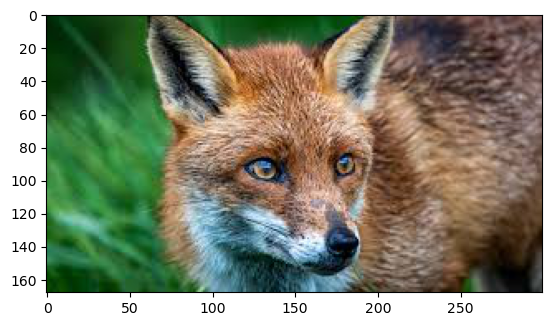

In [47]:
img_path = "randphotos/foximage1.jpg"
img = image.load_img(img_path)
plt.imshow(img)
plt.show()

##### SOURCE - For predicting new data below - TF guide
https://www.tensorflow.org/tutorials/images/classification#predict_on_new_data

In [50]:
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = Batchnorm_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))


1/1 [==============================] - 0s 20ms/step
This image most likely belongs to red_fox with a 12.51 percent confidence.


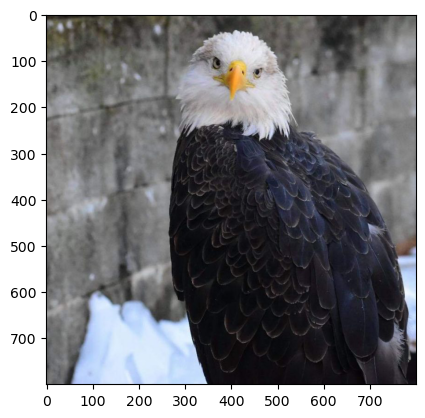

In [54]:
img_path = "randphotos/eagleimage2.jpg"
img = image.load_img(img_path)
plt.imshow(img)
plt.show()

In [55]:
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = Batchnorm_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))


1/1 [==============================] - 0s 19ms/step
This image most likely belongs to raven with a 12.51 percent confidence.


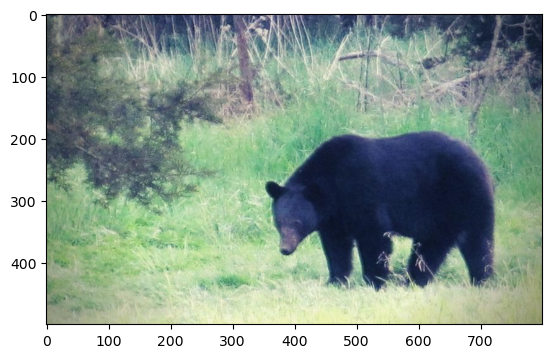

In [56]:
img_path = "randphotos/blackbear1.jpg"
img = image.load_img(img_path)
plt.imshow(img)
plt.show()

In [57]:
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = Batchnorm_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))


1/1 [==============================] - 0s 19ms/step
This image most likely belongs to black_bear with a 12.52 percent confidence.


# Summary and Next Steps